# Tunneling through a barrier

In Lecture 10, we developed some solutions for the stationary Schrödinger equation. We solved the harmonic oscillator or the particle in a box model. All of this did not give any dynamics of particles in potentials but rather a static picture. Today we would like to consider the time dependent Schrödinger equations which yields the dynamics of the system. We will develop a solution based on Fourier transforms, as we still have to practice that a bit.

In [526]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import *
from scipy.sparse import diags
from scipy.fftpack import fft,ifft
from time import sleep,time
from scipy import sparse as sparse
from scipy.sparse import linalg as ln

from ipycanvas import MultiCanvas, hold_canvas,Canvas


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Schrödinger equation for the momentum

This time we want to solve the Schrödinger equation for some special situation i.e. a wave packet that travels towards a barrier.
We have written the Schrödinger equation before, but shortly need that again

\begin{equation}
i\hbar\frac{\partial \Psi(x,t)}{\partial t} = \left ( \frac{-\hbar^2 }{2m}\frac{\partial^2}{\partial x^2}+V(x,t) \right ) \Psi(x,t)
\end{equation}

While this is the Schrödinger equation in position space, we may also obtain a Schrödinger equation for the momentum (k-) space. To do so, we take the fourier transform of the wavefunction 

\begin{equation}
\tilde{\Psi}(k,t)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty} \Psi(x,t)e^{-ikx} dx
\end{equation}

which yields the wavefunction in momentum space. 

We can also do that backwards to express the relation between the position space and the momentum space wavefunction.

\begin{equation}
\Psi(x,t)=\frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty}\tilde{\Psi}(k,t)e^{ikx}dk
\end{equation}

If we insert the latter equation into the Schrödinger equation we onbtain 

\begin{equation}
i\hbar \frac{\partial \tilde{\Psi}}{\partial t}=\frac{\hbar^{2}k^{2}}{2m}\tilde{\Psi}+V\left (i\frac{\partial }{\partial k}\right ) \tilde{\Psi}
\end{equation}

which is exactly this Schrödinger equation in momentum space.



## Cranck Nicolson Solution

We will pursue two different numerical solutions. The first solution, will be equivalent to the solution of the diffusion equation we did in Lecture 7. Here we need to write our Hamilton operator as a matrix with the second derivative and the potential. Lets assume you know how to create this matrix also from the last lecture. 

To get the time dependence we can approximate 

$$
\frac{\Psi(x,t+dt)-\Psi(x,t)}{dt}\approx -i H\Psi(x,t)
$$

and similarly

$$
\frac{\Psi(x,t+dt)-\Psi(x,t)}{dt}\approx -i H\Psi(x,t+dt)
$$

Therefore 

$$
\frac{\Psi(x,t+dt)-\Psi(x,t)}{dt}\approx \frac{1}{2i} H\Psi(x,t)\frac{1}{2i} H\Psi(x,t+dt)
$$

or

$$
\left(1-\frac{dt}{2i} H\right)\Psi(x,t+dt)=\left(1+\frac{dt}{2i} H\right)\Psi(x,t)
$$

and finally

$$
\Psi(x,t+dt)=\left(1-\frac{dt}{2i} H\right)^{-1}\left(1+\frac{dt}{2i} H\right)\Psi(x,t)
$$

Once we have calculated the Matrix of the hamiltonian and have provided an initial wavepacket, we can immediately propagate the initial wavepacket to later times. This seems easy with what we learned earlier.

### Setup Domain

In [651]:
N=500
x, dx = np.linspace(-100, 100, N, retstep=True)
prob = np.zeros(n_points)

dt=0.5

### Initial Conditions

Next we define the initial gaussian wavepacket with a certain momentum given by the wavenumber $k_{0}$.

In [652]:
sigma0=5.0  # initial width
x0=-50.0 ## initial position
k0=1.4 ## initial momentum

norm = (2.0 * np.pi * sigma0**2)**(-0.25)
psi = np.exp(-(x - x0)**2 / (4.0 * sigma0**2),dtype=complex)
psi *= np.exp(1.0j * k0 * x)
psi *= (2.0 * np.pi * sigma0**2)**(-0.25)

### Matrix Setp

In [653]:
barrier_width=5
barrier_height=1.
potential = np.array([barrier_height if 0.0 < x < barrier_width else 0.0 for x in x])

In [654]:
h_diag = np.ones(n_points) / dx**2 + potential
h_non_diag = np.ones(n_points - 1) * (-0.5 / dx**2)
hamiltonian = sparse.diags([h_diag, h_non_diag, h_non_diag], [0, 1, -1])

### Propagation Matrix

In [655]:
implicit = (sparse.eye(n_points) - dt / 2.0j * hamiltonian).tocsc()
explicit = (sparse.eye(n_points) + dt / 2.0j * hamiltonian).tocsc() 
evolution_matrix = ln.inv(implicit).dot(explicit).tocsr()

### Animation setup

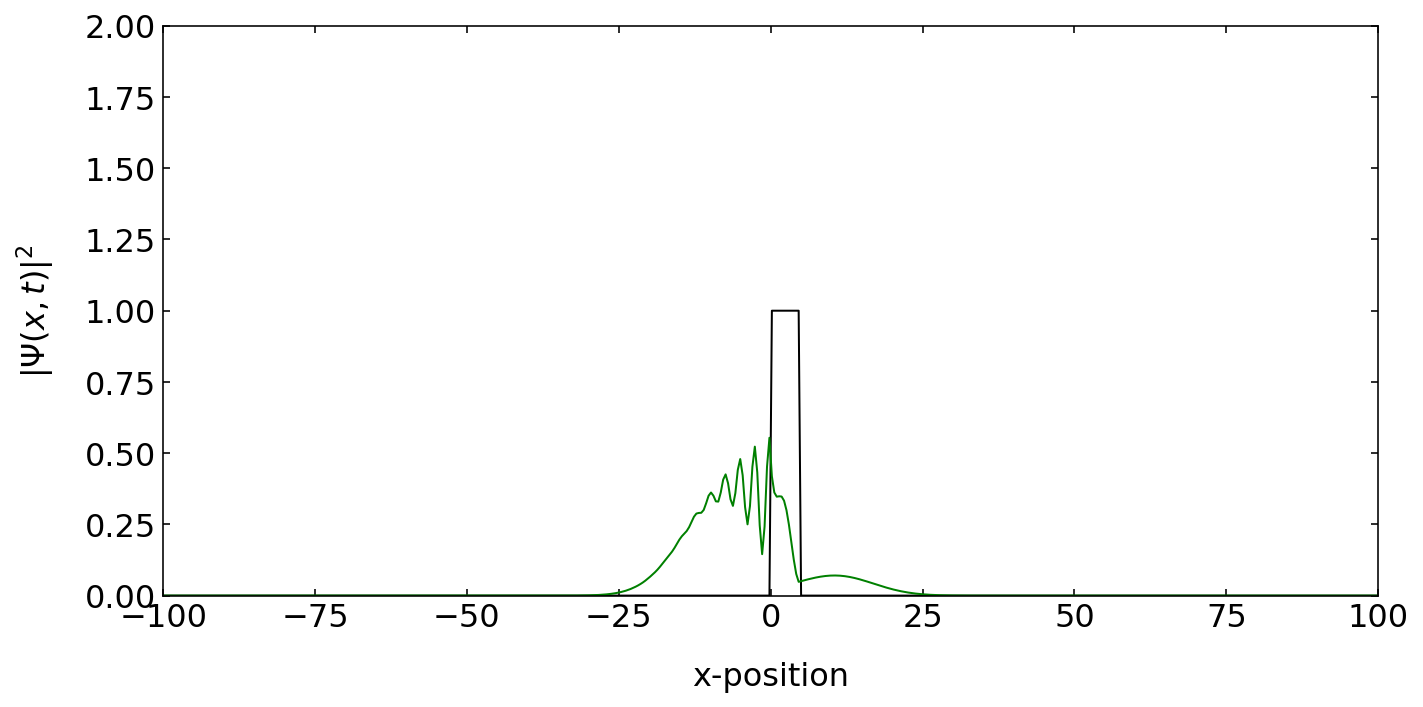

In [645]:
prob = abs(psi)**2
fig, ax = plt.subplots(1,1,figsize=(10,5))
plt.xlim(-100,100)
plt.ylim(0,2)
plt.xlabel('x-position')
plt.ylabel(r'$|\Psi(x,t)|^2$')
plt.tight_layout()  
plt.plot(x,potential,'k')
#ax.plot(x,20*prob,'g')
plt.draw()

background = fig.canvas.copy_from_bbox(ax.bbox)
points=ax.plot(x,20*prob,'g')[0]

plt.close() 

In [656]:
prob = abs(psi)**2
fig, ax = plt.subplots(1,1,figsize=(10,5))
plt.xlim(-100,100)
plt.ylim(0,2)
plt.xlabel('x-position')
plt.ylabel(r'$|\Psi(x,t)|^2$')
plt.tight_layout()  
plt.plot(x,potential,'k')
#ax.plot(x,20*prob,'g')
plt.draw()

background = fig.canvas.copy_from_bbox(ax.bbox)
points=ax.plot(x,20*prob,'g')[0]

plt.close() 

### Animation

In [657]:
canvas = Canvas(width=800, height=380,sync_image_data=False)
display(canvas)

Canvas(height=380, width=800)

In [658]:
for i in range(100):
    psi = evolution_matrix.dot(psi)
    prob = abs(psi)**2

    norm = sum(prob)
    prob /= norm
    psi /= norm**0.5
    fig.canvas.restore_region(background)
    ax.draw_artist(points)
    points.set_data(x,20*prob)

    fig.canvas.blit(ax.bbox)
    X = np.array(fig.canvas.renderer.buffer_rgba())

    with hold_canvas(canvas): 
        canvas.clear()
        canvas.put_image_data(X)
        sleep(0.02)

## Split Step Method

If we look at bit closer at the two Schrödinger equations above, we recognize that there is some symmetry in the two Schrödinger equations, which we can use to calculate the time-dependence of the wave function. This type of method is called the split step method.

We may substitute in the right side of the position Schrödinger equation 

\begin{equation}
\hat{D}=\frac{-\hbar^2 }{2m}\frac{\partial^2}{\partial x^2}
\end{equation}

and 

\begin{equation}
\hat{N}=V(x,t) 
\end{equation}

such that 

$$
i\hbar\frac{\partial \Psi(x,t)}{\partial t} = [\hat{D}+\hat{N}]\Psi
$$

with the solution 

$$
\Psi(x,t)=e^{-i(\hat{D}+\hat{N})t/\hbar}\Psi(x,0)
$$


If we only make a small timestep $dt$, we can write the latter equation also as

$$
\Psi(x,t+dt)=e^{-i\hat{D}dt/\hbar}e^{-i\hat{N}dt/\hbar} \Psi(x,t)
$$


We may now turn to momentum space by taking the Fourier transform $F$

$$
\tilde{\Psi}(k,t+dt)=F\left [e^{-i\hat{D}dt/\hbar}e^{-i\hat{N}dt/\hbar}\right ]\tilde{\Psi}(k,t)
$$

What we know now from the momentum Schrödinger equation is that the operator $\hat{D}$ will just turn into a multiplication with $\hbar k^2/2m$ in momentum space and therefore 

$$
\tilde{\Psi}(k,t+dt)=e^{i\frac{\hbar k^2}{2m}dt}F\left [e^{-i\hat{N}dt/\hbar}\right ]\tilde{\Psi}(k,t)
$$

Thus if we just do the inverse Fourier transform of that, we obtain

$$
\Psi(x,t+dt)=F^{-1}\left [ e^{i\frac{\hbar k^2}{2m}dt} F\left [e^{-i\hat{N}dt/\hbar}\Psi(x,t) \right ]  \right]
$$


This is the receipe we want to solve the time dependent Schrödinger equation.

In [659]:
#some constants
hbar=1
m=1

In [660]:
def gauss_x(x, sigma, x0, k0):
    return (np.exp(-0.5 * ((x - x0)/ sigma) ** 2 + 1j * x * k0)/(sigma * np.sqrt(np.pi)))

In [661]:
N = 2 ** 11
dx = 0.1
x = dx * (np.arange(N) - 0.5 * N)

In [662]:
dt = 0.005

In [663]:
V0 = 1
L = hbar / np.sqrt(2 * V0)
a = 3 * L
a=5
V_x =V0*(np.heaviside(x,1)-np.heaviside(x-a,1))
V_x[np.abs(x) > 98] = 1e6

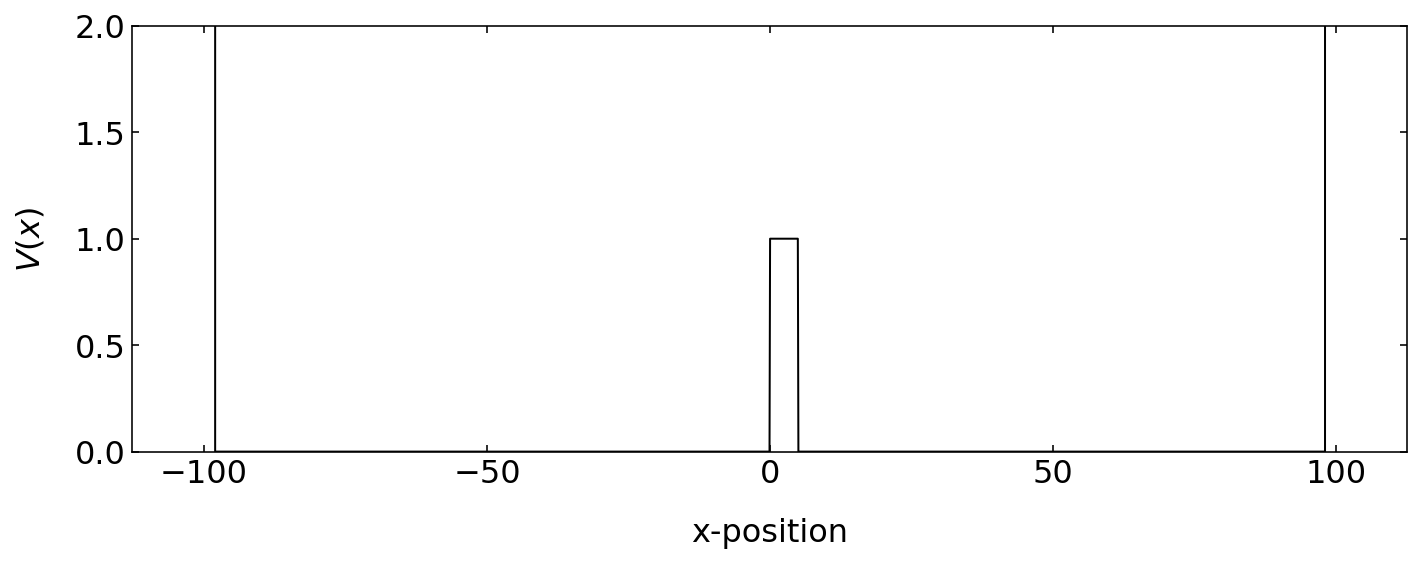

In [664]:
plt.figure(figsize=(10,4))
plt.plot(x,V_x,'k')
plt.ylim(0,2)
plt.xlabel('x-position')
plt.ylabel('$V(x)$')
plt.tight_layout()
plt.show()

In [665]:
p0 = np.sqrt(2 * m * 0.2 * V0)
dp2 = p0 * p0 * 1./80
d = hbar / np.sqrt(2 * dp2)
k0 = 2*p0 / hbar
v0 = p0 /m

k0=1
x0=-50
psi_x0 = gauss_x(x, d, x0, k0)


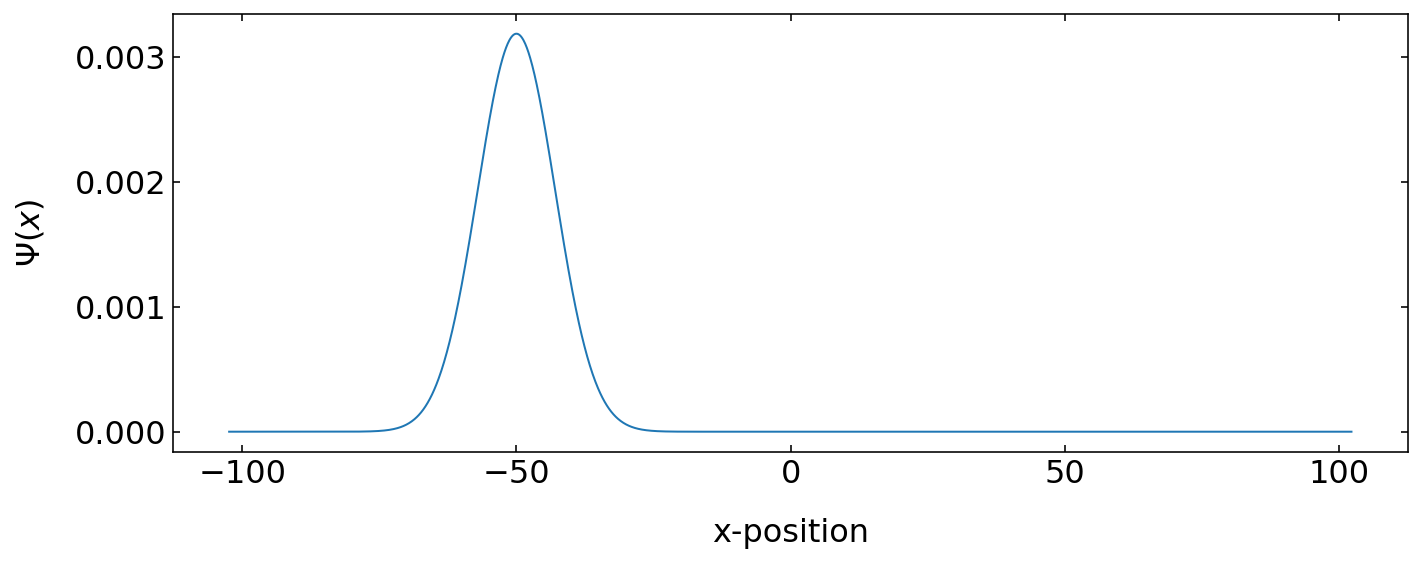

In [666]:

plt.figure(figsize=(10,4))
plt.plot(x,np.abs(psi_x0)**2)
plt.xlabel('x-position')
plt.ylabel('$\Psi(x)$')
plt.tight_layout()
plt.show()

In [673]:
N=len(x)
dx=x[1]-x[0]
k0=-np.pi/dx
dk = 2 * np.pi / (N * dx)
k = k0 + dk * np.arange(N)

In [674]:
psi_x=psi_x0.copy()

psi_modx=psi_x*np.exp(-1j * k[0] * x)* dx / np.sqrt(2 * np.pi)
phase_x=np.exp(-1j*V_x*dt/hbar)
phase_k=np.exp(-1j*hbar*k**2/m*dt)

In [675]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
plt.xlim(-100,100)
plt.ylim(0,2)
plt.xlabel('x-position')
plt.ylabel(r'$|\Psi(x,t)|^2$')
plt.tight_layout()  
plt.plot(x,V_x,'k')
plt.draw()

background = fig.canvas.copy_from_bbox(ax.bbox)
points=ax.plot(x,np.abs(psi_modx)**2,'g')[0]

plt.close() 

In [676]:
## setup the canvas
canvas = Canvas(width=800, height=380,sync_image_data=False)
display(canvas)

Canvas(height=380, width=800)

In [683]:
for i in range(10):
    fig.canvas.restore_region(background)
    ax.draw_artist(points)
    for j in range(100):
        tmp=ifft(phase_k*fft(psi_modx*phase_x))
        psi_modx=tmp
    points.set_data(x,1e5*np.abs(psi_modx)**2)

    fig.canvas.blit(ax.bbox)
    X = np.array(fig.canvas.renderer.buffer_rgba())

    
    with hold_canvas(canvas): 
        canvas.clear()
        canvas.put_image_data(X)
        sleep(0.01)